# Dealing with outliers
- Look for the Outliers. Fix them if needed, using a couple of techniques before deciding which is best.

Identifying outliers in 'price', 'date_of_transfer', 'property_type', 'is_new', 'duration', and 'ppdcategory_type'

In [16]:
# Import
import pyarrow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import dates
from scipy.stats import gaussian_kde
import seaborn as sns

In [17]:
# Load
df = pd.read_parquet('data/initial_cleaning.parquet', engine='pyarrow')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22489348 entries, 0 to 22489347
Data columns (total 9 columns):
 #   Column            Dtype         
---  ------            -----         
 0   price             int64         
 1   date_of_transfer  datetime64[ns]
 2   property_type     object        
 3   is_new            bool          
 4   duration          object        
 5   city              object        
 6   district          object        
 7   county            object        
 8   ppdcategory_type  object        
dtypes: bool(1), datetime64[ns](1), int64(1), object(6)
memory usage: 1.4+ GB


# Price

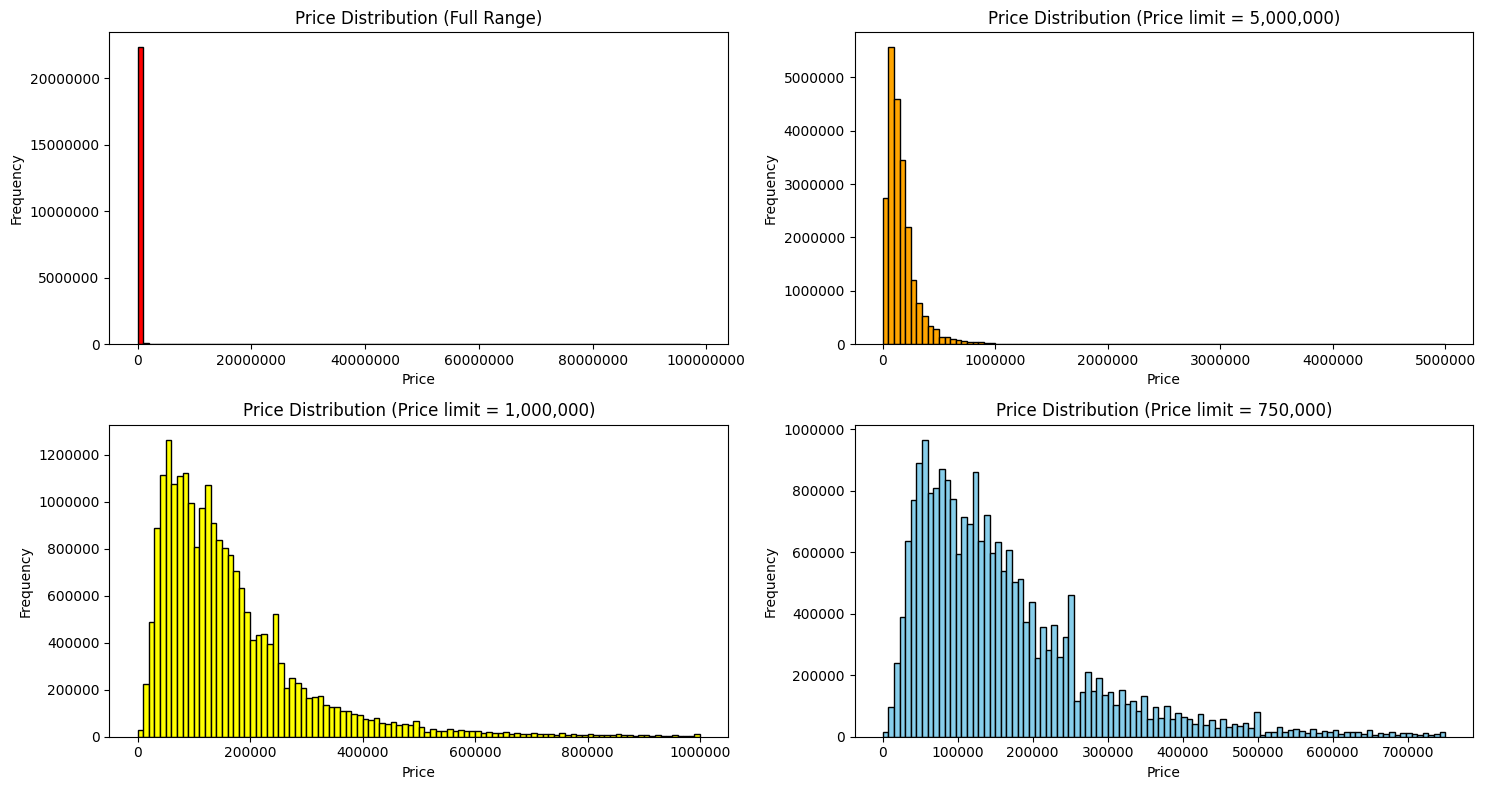

Total = 22489348
Highest price: 98900000
Number of the highest price: 1
Lowest price: 1
Number of the lowest price: 92
Q1 = 75000
Q3 = 210000
IQR = 135000
22167364 < 750,000 < 310647
22331444 < 1,000,000 < 152200
22481099 < 5,000,000 < 8025


In [19]:
# Distribution of 'price'
plt.figure(figsize=(15, 8))

# Without range specification
plt.subplot(2, 2, 1)
plt.hist(df['price'], bins=100, color='red', edgecolor='black')
plt.title('Price Distribution (Full Range)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter())
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='x')
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='y')

# With 5,000,000
plt.subplot(2, 2, 2)
plt.hist(df['price'], bins=100, range=(0, 5000000), color='orange', edgecolor='black')
plt.title('Price Distribution (Price limit = 5,000,000)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter())
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='x')
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='y')

# With 1,000,000
plt.subplot(2, 2, 3)
plt.hist(df['price'], bins=100, range=(0, 1000000), color='yellow', edgecolor='black')
plt.title('Price Distribution (Price limit = 1,000,000)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter())
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='x')
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='y')

# With range 750,000
plt.subplot(2, 2, 4)
plt.hist(df['price'], bins=100, range=(0, 750000), color='skyblue', edgecolor='black')
plt.title('Price Distribution (Price limit = 750,000)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter())
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='x')
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='y')

plt.tight_layout()
plt.show()

print('Total =', sum(df['price'] > 0))
print("Highest price:", h := df['price'].max())
print("Number of the highest price:", len(list(filter(lambda x:x==h, df['price']))))
print("Lowest price:", l := df['price'].min())
print("Number of the lowest price:", len(list(filter(lambda x:x==l, df['price']))))
print('Q1 =', q1:=int(df['price'].quantile(0.25)))
print('Q3 =', q3:=int(df['price'].quantile(0.75)))
print('IQR =', int(q3 - q1))
print(sum(df['price'] < 750000), '< 750,000 <', sum(df['price'] > 750000))
print(sum(df['price'] < 1000000), '< 1,000,000 <', sum(df['price'] > 1000000))
print(sum(df['price'] < 5000000), '< 5,000,000 <', sum(df['price'] > 5000000))

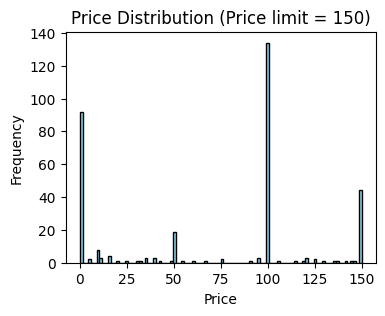

In [20]:
plt.figure(figsize=(4, 3))

# With range 150
plt.hist(df['price'], bins=100, range=(0, 150), color='skyblue', edgecolor='black')
plt.title('Price Distribution (Price limit = 150)')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.show()

In [21]:
outliers_df = df[df['price'] <= 750000]
outliers_df = outliers_df[outliers_df['price'] >= 75]

print('With outliers:', len(df))
print('Without outliers:', len(outliers_df))

With outliers: 22489348
Without outliers: 22178558


# Is new

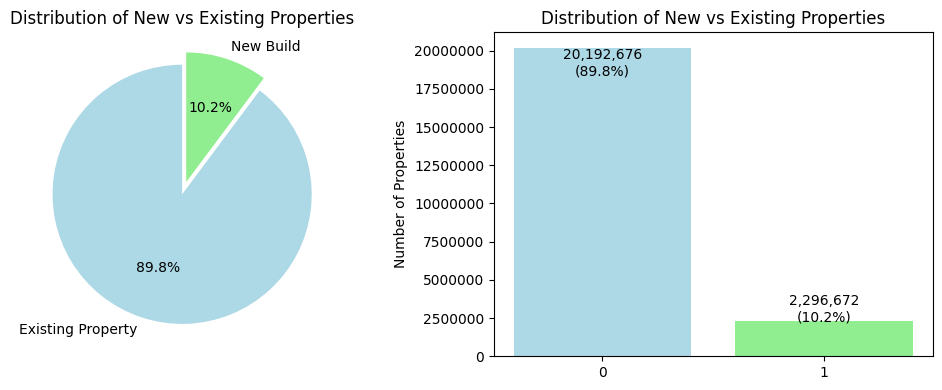

In [22]:
# Distribution of 'is_new'
plt.figure(figsize=(10, 4))

# Pie chart
plt.subplot(1, 2, 1)
is_new_counts = df['is_new'].value_counts()
plt.pie(is_new_counts,
       labels=['Existing Property', 'New Build'] if is_new_counts.index.tolist() == [0, 1] else ['New Build', 'Existing Property'],
       colors=['lightblue', 'lightgreen'],
       autopct='%1.1f%%',
       startangle=90,
       explode=(0, 0.1))
plt.title('Distribution of New vs Existing Properties')

# Bar Chart
plt.subplot(1, 2, 2)
labels = ['Existing Property', 'New Build'] if is_new_counts.index.tolist() == [0, 1] else ['New Build', 'Existing Property']
plt.bar(labels, is_new_counts.values, color=['lightblue', 'lightgreen'])
plt.title('Distribution of New vs Existing Properties')
plt.ylabel('Number of Properties')
plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter())
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='x')
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='y')

# Add value labels on top of bars
for i, v in enumerate(is_new_counts.values):
   plt.text(i, v*0.9, f'{v:,}\n({v/sum(is_new_counts.values)*100:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()



# Duration

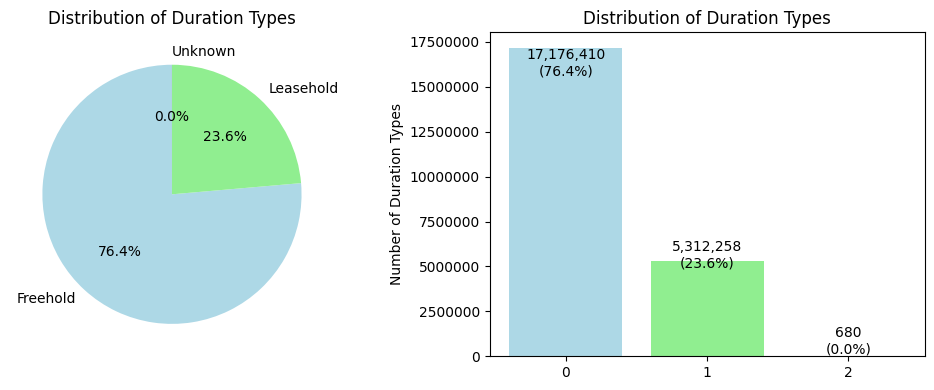

In [23]:
# Distribution of 'duration'
plt.figure(figsize=(10,4))

# Pie chart
plt.subplot(1, 2, 1)
duration_counts = df['duration'].value_counts()
labels_duration = {
   'F': 'Freehold',
   'L': 'Leasehold',
   'U': 'Unknown'
}
plt.pie(duration_counts,
       labels=[labels_duration[x] for x in duration_counts.index],
       colors=['lightblue', 'lightgreen', 'red'],
       autopct='%1.1f%%',
       startangle=90)
plt.title('Distribution of Duration Types')

# Bar Chart
plt.subplot(1, 2, 2)
labels = [labels_duration[x] for x in duration_counts.index]
plt.bar(labels, duration_counts.values, color=['lightblue', 'lightgreen', 'red'])
plt.title('Distribution of Duration Types')
plt.ylabel('Number of Duration Types')
plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter())
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='x')
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='y')

# Add value labels on top of bars
for i, v in enumerate(duration_counts.values):
   plt.text(i, v*0.9, f'{v:,}\n({v/sum(duration_counts.values)*100:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [24]:
print('With outliers:', len(outliers_df))

outliers_df = outliers_df[~(outliers_df['duration'] == 'U')]

print('Without outliers:', len(outliers_df))

With outliers: 22178558
Without outliers: 22177887


# Property type

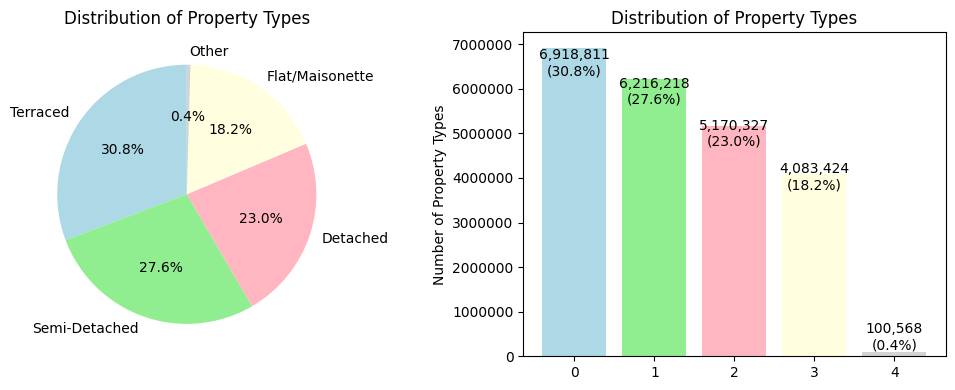

In [25]:
# Distribution of 'property_type'
plt.figure(figsize=(10, 4))

# Pie chart
plt.subplot(1, 2, 1)
property_counts = df['property_type'].value_counts()
labels_property = {
   'T': 'Terraced',
   'S': 'Semi-Detached',
   'D': 'Detached',
   'F': 'Flat/Maisonette',
   'O': 'Other'
}
plt.pie(property_counts, 
       labels=[labels_property[x] for x in property_counts.index],
       colors=['lightblue', 'lightgreen', 'lightpink', 'lightyellow', 'lightgray'],
       autopct='%1.1f%%',
       startangle=90)
plt.title('Distribution of Property Types')

# Bar Chart
plt.subplot(1, 2, 2)
labels = [labels_property[x] for x in property_counts.index]
plt.bar(labels, property_counts.values, color=['lightblue', 'lightgreen', 'lightpink', 'lightyellow', 'lightgray'])
plt.title('Distribution of Property Types')
plt.ylabel('Number of Property Types')
plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter())
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='x')
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='y')

# Add value labels on top of bars
for i, v in enumerate(property_counts.values):
   plt.text(i, v*0.9, f'{v:,}\n({v/sum(property_counts.values)*100:.1f}%)', ha='center', va='bottom')


plt.tight_layout()
plt.show()

# PPD Category

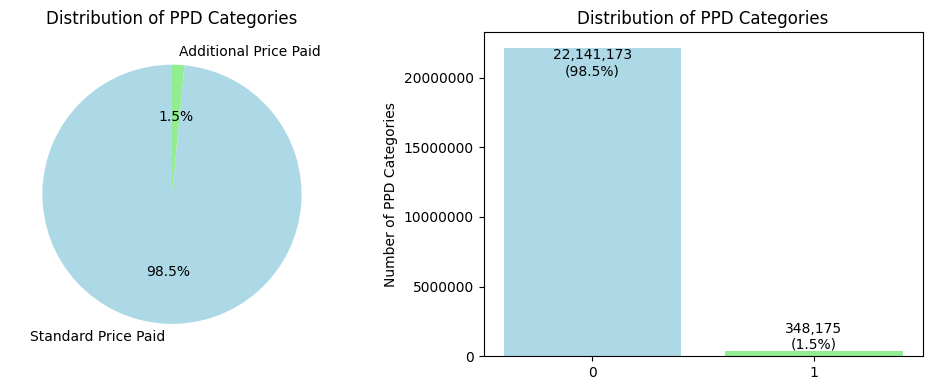

In [26]:

# Distribution of 'ppdcategory_type'
plt.figure(figsize=(10, 4))

# Pie chart
plt.subplot(1, 2, 1)
ppd_counts = df['ppdcategory_type'].value_counts()
labels_ppd = {
   'A': 'Standard Price Paid',
   'B': 'Additional Price Paid'
}
plt.pie(ppd_counts,
       labels=[labels_ppd[x] for x in ppd_counts.index],
       colors=['lightblue', 'lightgreen'],
       autopct='%1.1f%%',
       startangle=90)
plt.title('Distribution of PPD Categories')

# Bar Chart
plt.subplot(1, 2, 2)
labels = [labels_ppd[x] for x in ppd_counts.index]
plt.bar(labels, ppd_counts.values, color=['lightblue', 'lightgreen'])
plt.title('Distribution of PPD Categories')
plt.ylabel('Number of PPD Categories')
plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter())
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='x')
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='y')

# Add value labels on top of bars
for i, v in enumerate(ppd_counts.values):
   plt.text(i, v*0.9, f'{v:,}\n({v/sum(ppd_counts.values)*100:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [28]:
# Save data in parquet format
outliers_df = outliers_df.reset_index(drop=True)
print(outliers_df.info())
outliers_df.to_parquet('data/outliers.parquet', engine='pyarrow')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22177887 entries, 0 to 22177886
Data columns (total 9 columns):
 #   Column            Dtype         
---  ------            -----         
 0   price             int64         
 1   date_of_transfer  datetime64[ns]
 2   property_type     object        
 3   is_new            bool          
 4   duration          object        
 5   city              object        
 6   district          object        
 7   county            object        
 8   ppdcategory_type  object        
dtypes: bool(1), datetime64[ns](1), int64(1), object(6)
memory usage: 1.3+ GB
None
